In [1]:
%matplotlib inline

In [2]:
import numpy as np
import pandas as pd
import scipy as sp

import matplotlib.pyplot as plt
import scikitplot as skplt
import seaborn as sns

import librosa as lb
import librosa.display as lbd

from sklearn.metrics import classification_report, accuracy_score, make_scorer
from sklearn.preprocessing import StandardScaler, minmax_scale
from sklearn.feature_selection import RFECV
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

import os
import itertools
import IPython.display as ipd
from tabulate import tabulate
import warnings

import pickle

# Music Genre Classification
## Author: Tsvetoslav Nikolov

## Abstract

Music is such a nice art, which can change the way we think in a different direction. Now imagine a computer that can tell you the genre of a given song. This powerful magic has a lot of use cases. For example, it can be very useful in one big recommendation system, or just to classify songs and create a playlist. In this paper, you will find information about the process of the research(the way I do it). The main idea here is to understand the process, the steps, but the most important thing you will learn is how to answer the biggest question - "Why?".

# Preparing our data

## Meet our data

When we hear the word "audio" one bulb in our head turns on because we know that this isn't an ordinary data type. This is spatial data which we have to transform in some way so we can use it. This is called "feature extraction". We're going to "extract" some features from our audio files. 

After the research step, I found a cool dataset called <a href="http://marsyas.info/downloads/datasets.html">GTZAN</a>. It consists of 1000 audio tracks each 30 seconds long. The dataset has a total of 10 genres, each represented by 100 tracks. The tracks are all packed in 22 050 Hz Mono 16-bit audio files. 

The features to extract

Time-domain related:
<ol>
    <li>Zero crossing rate</li>
    <li>Tempo</li>
    <li>RMSE</li>
</ol>

Frequency-domain related:
<ol>
    <li>Spectral Centroid</li>
    <li>Spectral Bandwich</li>
    <li>Spectral Contrast</li>
    <li>Spectral Rolloff</li>
    <li>13 MFCCs(Mel-Frequency Cepstral Coefficients)</li>
    <li>Chroma Frequencies</li>
</ol>

Every one of these features is described by its mean and standard deviation(the 1st and the 2nd moments from one distribution).
You can find more information about these features below. But first, let's learn the fundamental theory. 

What does audio mean? Well, it's pretty easy, it is a function that varies over time, so it is a signal. The simplest way to plot an audio data is to plot its "waveform", or in other words, to plot the function 𝑓(𝑡) where t stands for "time" on the x-axis. On the y-axis, on the other hand, we have the amplitude of the signal. Let's see an example.


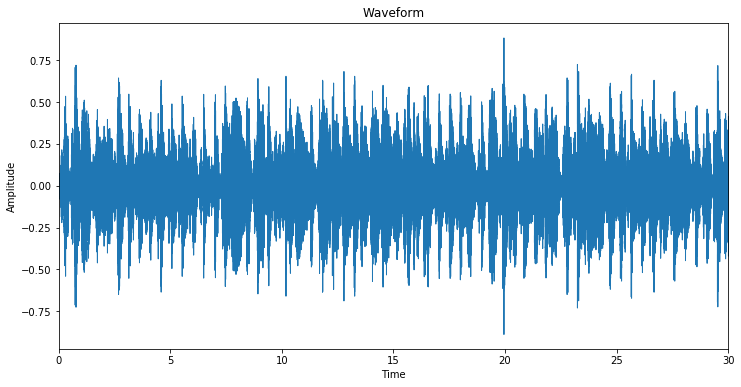

In [3]:
example_audio_data, example_audio_sr = lb.load("./Data/blues.00000.wav")


def plot_waveform(audio_data, sr = 22050, title="Waveform", show=True):    
    plt.figure(figsize=(12, 6))
    lbd.waveplot(audio_data, sr)
    plt.title(title)
    plt.ylabel("Amplitude")
    if show:
        plt.show()
    
plot_waveform(example_audio_data, example_audio_sr)

As you can see it's not so complicated, but it's fundamental. We're going to use this representation later also. Another thing, which is important to know is that the audio wave itself is analog and we need to convert it to digital. There is something called a "sample-rate". This is how many samples we have per second. For instance, the example above is sampled with a 22 050 sample rate. We take 22 050 equally spaced points on the signal function 𝑓(𝑡)f(t) and compute their Y. And the other important thing to know here is that the sample rate determines the highest frequency we can detect, which is half of the sample-rate. There is a lot of information here, but this is another topic... However, if you are interested in this, you should definitely check <a href="./MathAndMusicPaper/MathAndMusic.ipynb">this notebook</a> for more info.


Another way to plot an audio signal is to plot its 'spectrum'. This is the frequencies-amplitude representation computed by the Fourier transform. Again, if you don't know what this means, check <a href="./MathAndMusicPaper/MathAndMusic.ipynb">this notebook</a>(It contains information about Fourier Transform, Spectrum, Spectrogram(STFT), etc. ). But let's see how the spectrum looks like.

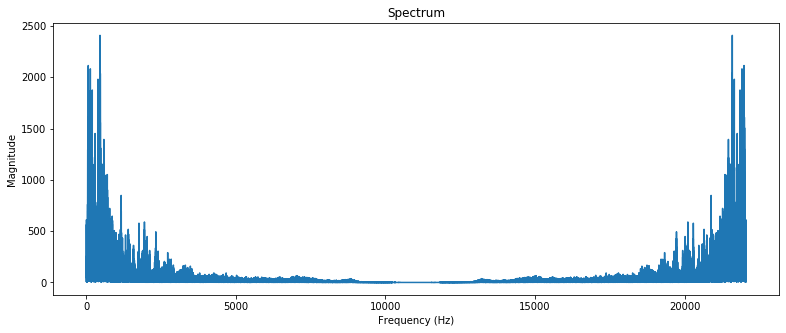

In [4]:
def plot_spectrum(audio_data, sr = 22050, title="Spectrum", show=True, g_type="linear"):
    #The fourier transform in just one line :D
    audio_data = sp.fft(audio_data)
    
    #The fourier transform itself gives us complex numbers, but need just the real part
    audio_data = np.absolute(audio_data)
    
    #Plot it
    f = np.linspace(0, sr, len(audio_data)) # frequency variable
    
    plt.figure(figsize=(13, 5))
    plt.plot(f, audio_data) # magnitude spectrum
    plt.yscale(g_type)
    plt.title(title)
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('Magnitude')
    if show:
        plt.show()
        
plot_spectrum(example_audio_data, example_audio_sr)

And maybe the most important audio representation when it comes to machine learning is something called "Spectrogram". Remember, with the spectrum, we have "Frequencies-Magnitude" representation of the audio, but in the spectrogram, we have "Time-Frequencies-Magnitude". In short words, we divide the signal in our waveform into small parts and then calculate the spectrum of every part. Then, we combine everything and the result is something like that.

And again...If you want to learn more about how this works, just read <a href="./MathAndMusicPaper/MathAndMusic.ipynb">my notebook</a> about mathematics in music.

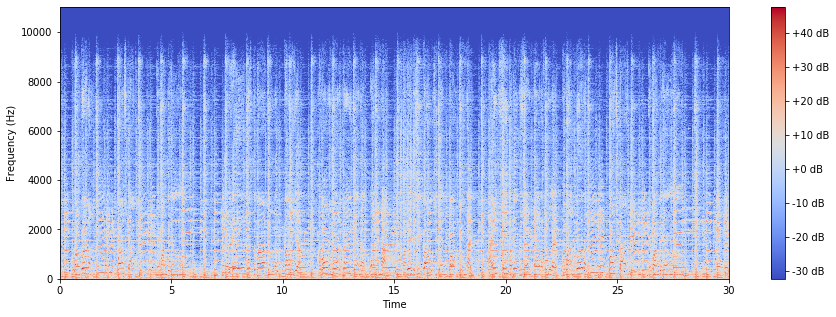

In [5]:
def plot_spectrogram(audio_data, sr = 22050,n_fft=2048, hop_length=512, title="", show=True, color_legend=True, g_type="linear"):
    hop_length = hop_length
    n_fft = n_fft
    audio_data = lb.stft(audio_data, n_fft=n_fft, hop_length=hop_length)
    audio_data = lb.amplitude_to_db(abs(audio_data))

    plt.figure(figsize=(15, 5))
    lbd.specshow(audio_data, sr=sr, hop_length=hop_length, x_axis='time', y_axis=g_type)
    if color_legend:
        plt.colorbar(format='%+2.0f dB')
    
    plt.title(title)
    plt.xlabel('Time')
    plt.ylabel('Frequency (Hz)')
    if show:
        plt.show()
        
plot_spectrogram(example_audio_data)

## Different Features
### Zero Crossing Rate

This feature represents the rate at which the signal changes from positive to negative or back(the rate at which the signal crosses "0"). Throughout metal and rock music, it typically has higher values. Fortunately,  Librosa has a method for us (as I always say ", in python you can make your life easier with just one import :D"). Librosa will return an array, which contains information about every sample. We have two states for every sample - "True" or "False". "True" means there is a zero-crossing and "False" means there is no zero-crossing.

4 zero crossings


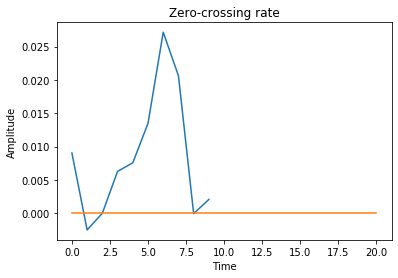

4


In [6]:
# Taking a fragment from the audio. Just to see it clearly
fragment = example_audio_data[120:130]

zero_crossings = lb.zero_crossings(example_audio_data[120:130], pad=False)
print(f'{sum(zero_crossings)} zero crossings')

plt.plot(fragment)
plt.plot(np.linspace(0, 20, 2), np.zeros(shape=2))

plt.title("Zero-crossing rate")
plt.xlabel("Time")
plt.ylabel("Amplitude")
plt.show()

print(zero_crossings.sum())

As you can see, there are 4 zero-crossings. But the name of this feature is "zero-crossing RATE", so we're going to use the rate. That's pretty easy, isn't it? We have two ways. The first one - divide the count of the crossings by the time, which is the 30s, and the second one - divide the count of the crossings by the count of the samples. The second one is more optimal, because of the speed. Think of this for a second, this is a global idea in machine learning. Everything in the world of ML is represented by matrices of numbers. And the smaller numbers we have, the easiest will be to train the algorithm. So the second method gives us a number between 0-1 and is perfect for this situation. Well, there is another option - the first way and then to use some kind of scalar, but let's stick to the second one for now. For our machine learning model, we'll use the method inside 'librosa.feature' module.

In [7]:
zero_crossing_rate = sum(lb.zero_crossings(example_audio_data)) / example_audio_data.shape[0]
zero_crossing_rate_faster = np.mean(lb.feature.zero_crossing_rate(example_audio_data))
print(zero_crossing_rate)
print(zero_crossing_rate_faster)

0.08315578563722247
0.08304482066898686


### Spectral Centroid
This is "the center of mass" of the frequencies which present in the sound. It can be measured as the weighted average of the sound frequencies.
$$ f_c = \frac{\sum_{k}s(k)f(k)}{\sum_{k}s(k)}$$

Where $s(k)$ is the magnitude of the kth bin in the spectrum and $f(k)$ is the frequency at this bin.

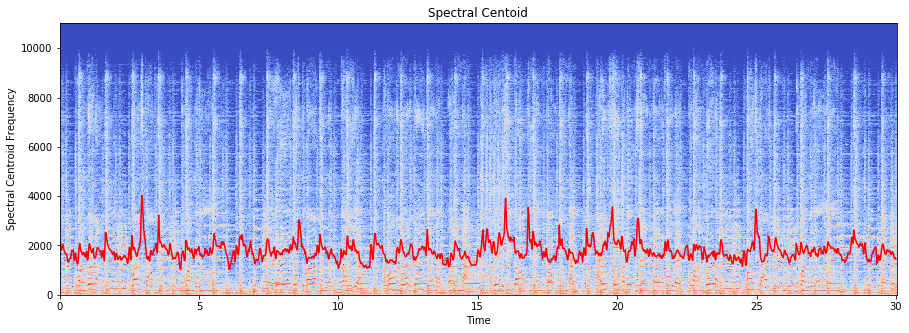

In [8]:
spectral_centroids = lb.feature.spectral_centroid(example_audio_data, sr=example_audio_sr)[0]

#Time variable
frames = range(len(spectral_centroids))
t = lb.frames_to_time(frames)

plot_spectrogram(example_audio_data, show=False, color_legend=False, title="Spectral Centoid")

plt.plot(t, spectral_centroids, color='r')

plt.xlabel("Time")
plt.ylabel("Spectral Centroid Frequency")

#plot the spectrogram with the same hop_length to see the relation
plt.show()


You will see the spectral centroid over the waveform representation in a lot of papers. But I think this is a better visualization because there is a more significant relation between spectral centroid and frequencies than between spectral centroid and amplitude.

Now let's see what is the mean.

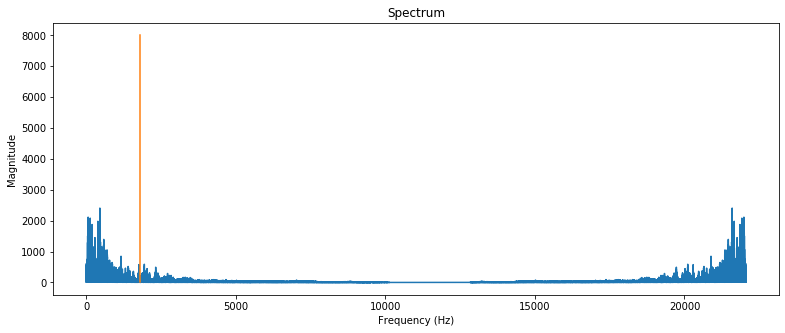

In [9]:
plot_spectrum(example_audio_data, example_audio_sr, show=False)
spectral_centroid_mean = np.mean(spectral_centroids)
plt.plot(2 * [spectral_centroid_mean], [0, 8000])
plt.show()

## Spectral Bandwith

The name of the feature tells us everything. Thas is the formula:

$$  \left[ \sum_k{S(k)(f(k) - f_c)^p}\right]^{\frac{1}{p}} $$

Where $S(k)$ is the magnitude at the kth bin in the spectrum, $f(k)$ is the frequency at bin <i>k</i> and $f_c$ stands for the spectral centroid. The default parameter p is 2, which is something like a weighted standard deviation.

<img src="Images/librosa-feature-spectral_bandwidth-1.png" />

## Spectral Contrast
This feature estimates the difference between the spectral peaks, spectral valley in 6(or we can choose a different number, it doesn't matter for now) "sub-bands". Keep in mind that I'm just briefly describing features here. If you want to know more about this feature in detail. Check out this <a href="http://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.583.7201&rep=rep1&type=pdf">paper</a>.

In [10]:
spectral_contrast = lb.feature.spectral_contrast(example_audio_data, example_audio_sr)
spectral_contrast.shape

(7, 1293)

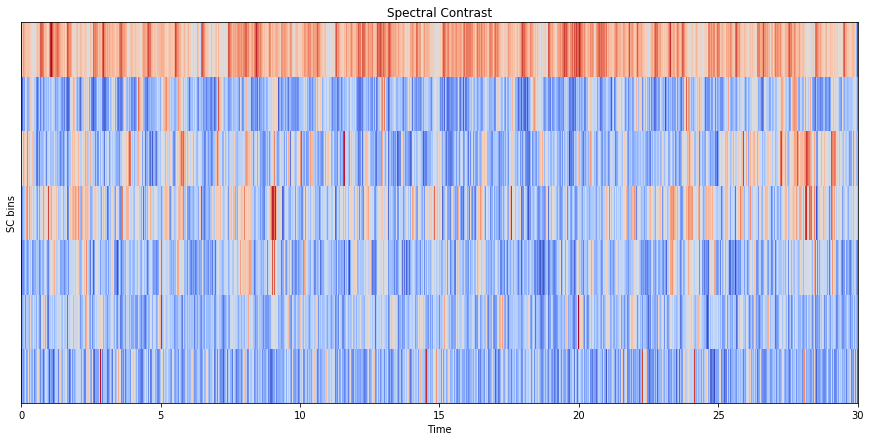

In [11]:
plt.figure(figsize=(15, 7))
sc = lb.frames_to_time(minmax_scale(spectral_contrast, axis=1))
lbd.specshow(sc, x_axis="time", cmap='coolwarm')
plt.title("Spectral Contrast")
plt.ylabel("SC bins")
plt.show()

## Spectral Rolloff

That's something like the spectral centroid, but this time we're not searching the mean frequency. We're searching the frequency below which lies a specified percentage of total spectral power, e.g. 85%.

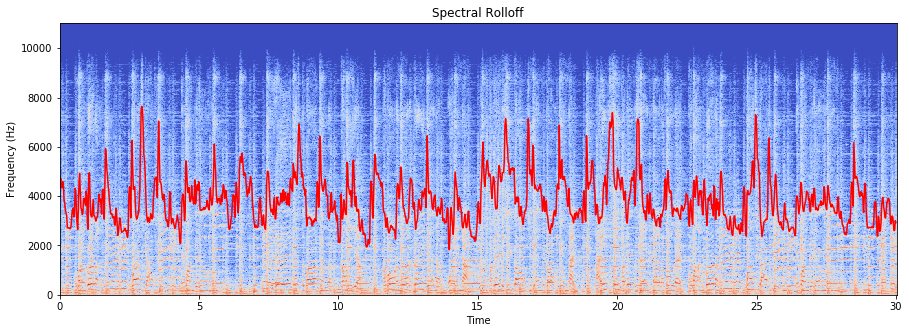

In [12]:
spectral_rolloff = lb.feature.spectral_rolloff(example_audio_data, example_audio_sr)[0]

#Time variable
frames_time = lb.frames_to_time(range(len(spectral_rolloff)))

plot_spectrogram(example_audio_data, show=False, color_legend=False, title="Spectral Rolloff")
plt.plot(frames_time, spectral_rolloff, color='r')
plt.show()

If we compute the mean, we should get the value of the overall frequency, below which lies 85% of the total spectral power.

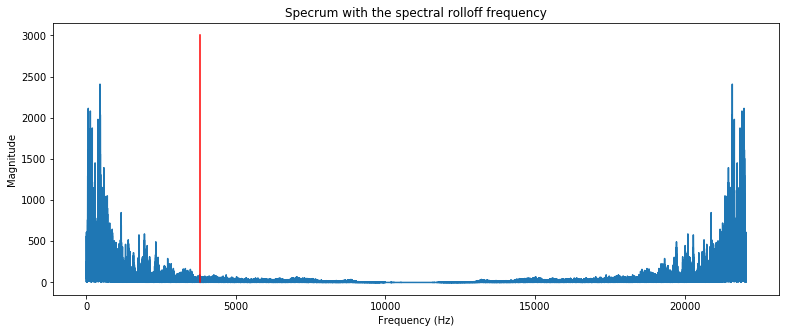

In [13]:
plot_spectrum(example_audio_data, example_audio_sr, show=False, title="Specrum with the spectral rolloff frequency")
plt.plot(2*[spectral_rolloff.mean()],[0, 3000], c="red")
plt.show()

Yeah, it works! We can see that this frequency is higher than the one from the spectral centroid, so it works.

## Mel-Frequency Cepstral Coefficients

MFCCs are a compact representation of the spectrum. They tell us information about the rate of change in different bands of the spectrum. A positive value of a coefficient means that most of the spectral energy lies in the low-frequencies. On the other side, if the value is for some reason negative, it means that the bigger part of the spectral energy is focused on the high-frequencies. The steps to compute these coefficients are:

<ol>
    <li>Frame the signal into short frames</li>
    <li>Do something called windowing to reduce what's called "Spectral leakage"</li>
    <li>Them the Discrete Fourier Transform comes in the game :D</li>
    <li>Apply Mel Filter Banks (Don't worry if you don't know what is this, I've described it below for you)</li>
    <li>Apply the log and get the log filterbank energy</li>
    <li>Now we have a spectrogram, but the coefficients of the filterbanks are heavily correlated so we need to decorrelate them. We can do this by applying the Discrete cosine transform(you can check it in Google, but the difference between DCF and DFF is that the DFF uses complex numbers as a result). This step is optional, but it's better if you do it.</li>
    <li>Get filterbanks energy value(as many as you want)</li>
</ol>

### Mel scale
We're all humans, right? We can hear everything in our frequency range(20Hz to 20kHz) with equal respect for every frequency? No, it's not perfectly correct. Imagine that you hear a tone which is 200Hz and then a tone which is 300Hz. Then you hear another tone which is 900Hz and then another one - 1000HZ. Your brain will process the information in the way where the distance between the first and the second tones is different from the distance between the third and the forth, although it's the same. <a href="https://en.wikipedia.org/wiki/Mel_scale">The Mel scale</a> is developed to capture such differences. And "Mel filterbanks" are nothing, but applying Mel scale to the spectrum. The formula is:

$$ m = 2595log_{10}(1 + \frac{f}{700}) $$


<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/a/aa/Mel-Hz_plot.svg/1920px-Mel-Hz_plot.svg.png"/>

As you can see we make the distance between low-frequency more drastic.
And let's see how Mel scale filterbanks look like.

<img src="https://www.researchgate.net/profile/Yusnita_Mohd_ali/publication/288632263/figure/fig1/AS:613909065121800@1523378735077/Mel-filter-banks-basis-functions-using-20-Mel-filters-in-the-filter-bank.png"/>

<img src="./Images/MFCCs.png"/>

If you're not familiar with audio filters and other stuff from here, check <a href="./MathAndMusicPaper/MathAndMusic.ipynb">my notebook</a>.

## Chroma

Chroma is a powerful representation of music audio. The spectrum is projected onto 12 bins representing the 12 distinct semitones of the musical octave. This projection is called "chromagram". It's like a spectrogram, but here we have musical tones instead of frequencies on the y-axis.

We're going to use the Chroma energy normalized statistics(CENS). The idea behind it is that when we take a bigger window, over which we take all of the statistics, we smooth all local deviations(which appear when we have trills or other ornaments). It just makes our representation smooth, which is good for music classification and finding a similarity.

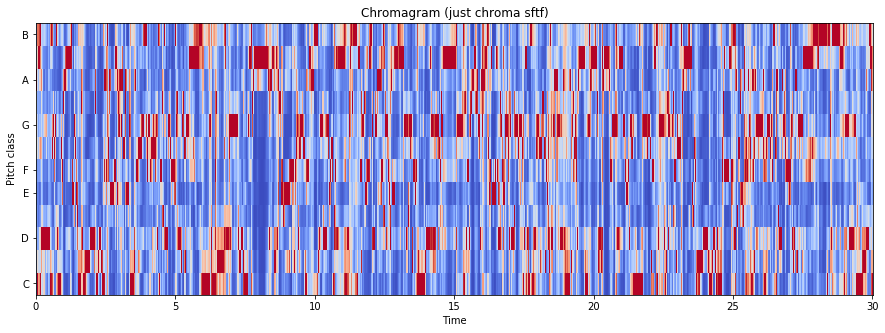

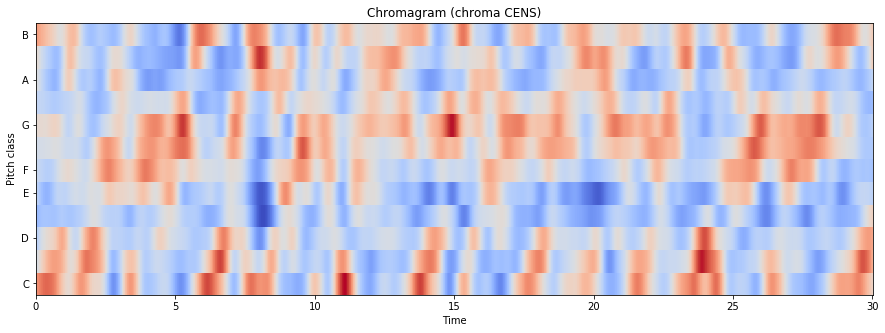

In [14]:
chromagram_sftf  = lb.feature.chroma_stft(example_audio_data, example_audio_sr)
chromagram_cens  = lb.feature.chroma_cens(example_audio_data, example_audio_sr)

plt.figure(figsize=(15, 5))
lbd.specshow(chromagram_sftf, x_axis='time', y_axis='chroma', hop_length=512, cmap='coolwarm')

plt.title("Chromagram (just chroma sftf)")
plt.show()

plt.figure(figsize=(15, 5))
lbd.specshow(chromagram_cens, x_axis='time', y_axis='chroma', hop_length=512, cmap='coolwarm')

plt.title("Chromagram (chroma CENS)")
plt.show()

### Create Our Dataset
In the beginning, we choose GTZAN dataset. Now let's extract the data from it. We're going too list every directory and calculate the mean and the standard deviation of every feature. Just to mention two more features here - Tempo and <a href="https://musicinformationretrieval.com/energy.html">RMSE</a>. I think everyone knows what the word "tempo" :D. And for the <a href="https://musicinformationretrieval.com/energy.html">RMSE</a> - this is simply the energy of the track.

<small>*Some cells may take too much time to load. Be careful about which cells to execute.</small>

In [15]:
def extract_features():    
    music_data = pd.DataFrame()
    genres = os.listdir("Data/genres")
    columns = ["zcr_mean","zcr_std","tempo","rmse_mean","rmse_std","sp_centroid_mean","sp_centroid_std","sp_bandwidth_mean","sp_bandwidth_std","sp_contrast_mean","sp_contrast_std","sp_rolloff_mean","sp_rolloff_std","chroma_mean","chroma_std"]
    for i in range(1, 27):
        if i % 2 != 0:
            columns.append("mfcc_"+str(i)+"_mean")
        else:
            columns.append("mfcc_"+str(i-1)+"_std")
    columns.append("genre")
    data = np.array([])
    for genre in genres:
        directory = "./Data/genres/" + genre
        files = os.listdir(directory)
        for file in files:
            file_dir = directory + "/" + file
            audio_data, audio_sr = lb.load(file_dir)
            zcr_mean = lb.feature.zero_crossing_rate(audio_data, audio_sr).mean()
            zcr_std = lb.feature.zero_crossing_rate(audio_data, audio_sr).std()
            envelope = lb.onset.onset_strength(audio_data, audio_sr)
            tempo = round(lb.beat.tempo(audio_data, audio_sr, onset_envelope = envelope)[0])
            rmse_mean = lb.feature.rmse(audio_data).mean()
            rmse_std = lb.feature.rmse(audio_data).std()
            sp_centroid_mean = lb.feature.spectral_centroid(audio_data, audio_sr).mean()
            sp_centroid_std = lb.feature.spectral_centroid(audio_data, audio_sr).std()
            sp_bandwidth_mean = lb.feature.spectral_bandwidth(audio_data, audio_sr).mean()
            sp_bandwidth_std = lb.feature.spectral_bandwidth(audio_data, audio_sr).std()
            sp_contrast_mean = lb.feature.spectral_contrast(audio_data, audio_sr).mean()
            sp_contrast_std = lb.feature.spectral_contrast(audio_data, audio_sr).std()
            sp_rolloff_mean = lb.feature.spectral_rolloff(audio_data, audio_sr).mean()
            sp_rolloff_std = lb.feature.spectral_rolloff(audio_data, audio_sr).std()
            chroma_mean = lb.feature.chroma_cqt(audio_data, audio_sr).mean()
            chroma_std = lb.feature.chroma_cqt(audio_data, audio_sr).std()

            
#             Compute our 20 MFCCs and take the average value for every on of them
            MFCCs_mean = lb.feature.mfcc(audio_data, audio_sr, n_mfcc=13).mean(axis=1)
            MFCCs_std = lb.feature.mfcc(audio_data, audio_sr, n_mfcc=13).std(axis=1)
            MFCCs = np.insert(MFCCs_std, np.arange(len(MFCCs_mean)), MFCCs_mean)
            filename = file
            file_data = np.concatenate([np.array([zcr_mean, zcr_std, tempo, rmse_mean, rmse_std, sp_centroid_mean, sp_centroid_std, sp_bandwidth_mean, sp_bandwidth_std, sp_contrast_mean,sp_contrast_std, sp_rolloff_mean, sp_rolloff_std, chroma_mean, chroma_std]), MFCCs, [genre]])
            data = np.append(data, file_data)
           
    music_data_gtzan = pd.DataFrame(data=features_data.reshape(-1, len(columns)), columns=columns)
    music_data_gtzan.to_csv("Data/music_features.csv")
    return music_data_gtzan


music_data = extract_features() if os.path.exists("Data/music_features.csv")==False else pd.read_csv("Data/music_features.csv", index_col=0)

# EDA

We've already extracted the data from the audio files. Let's see how our set actually looks.

In [16]:
print(f"Shape: {music_data.shape}")
music_data.head()

Shape: (1000, 42)


,zcr_mean,zcr_std,tempo,rmse_mean,rmse_std,sp_centroid_mean,sp_centroid_std,sp_bandwidth_mean,sp_bandwidth_std,sp_contrast_mean,...,mfcc_9_std,mfcc_10_mean,mfcc_10_std,mfcc_11_mean,mfcc_11_std,mfcc_12_mean,mfcc_12_std,mfcc_13_mean,mfcc_13_std,genre
0,0.082393,0.015000,123,0.130228,0.053167,1784.165850,360.241675,2002.449060,293.057608,20.526699,...,9.066653,10.976571,7.961552,-8.326572,7.859586,8.803791,7.158500,-3.672299,6.420079,blues
1,0.055741,0.022938,108,0.095948,0.048711,1530.176679,613.066125,2039.036516,462.432433,20.676128,...,12.888309,11.900497,10.215606,-5.555638,10.255419,5.376327,9.808018,-2.231760,8.056941,blues
2,0.075775,0.014547,161,0.175570,0.052401,1552.811865,395.559911,1747.702312,276.141616,22.197517,...,8.089991,9.718760,8.240683,-13.133803,7.601409,5.791199,8.029957,-8.907628,7.770788,blues
3,0.033182,0.011431,172,0.141093,0.079664,1070.106615,429.366909,1596.412872,407.972419,21.426268,...,9.597608,8.137606,8.444766,-3.200652,10.499366,6.079319,6.946366,-2.480173,7.536538,blues
4,0.100931,0.032724,136,0.091529,0.047994,1835.004266,586.003361,1748.172116,297.397392,21.466338,...,11.404971,1.207254,9.983766,-13.088417,8.958463,-2.813868,9.296807,-6.933384,9.463374,blues


Nothing here can surprise us. We have the filename plus all of the features with their means and standard deviations. Let's check the types of the columns and the count of tracks per genre.

In [17]:
music_data.dtypes

zcr_mean             float64
zcr_std              float64
tempo                  int64
rmse_mean            float64
rmse_std             float64
sp_centroid_mean     float64
sp_centroid_std      float64
sp_bandwidth_mean    float64
sp_bandwidth_std     float64
sp_contrast_mean     float64
sp_contrast_std      float64
sp_rolloff_mean      float64
sp_rolloff_std       float64
chroma_mean          float64
chroma_std           float64
mfcc_1_mean          float64
mfcc_1_std           float64
mfcc_2_mean          float64
mfcc_2_std           float64
mfcc_3_mean          float64
mfcc_3_std           float64
mfcc_4_mean          float64
mfcc_4_std           float64
mfcc_5_mean          float64
mfcc_5_std           float64
mfcc_6_mean          float64
mfcc_6_std           float64
mfcc_7_mean          float64
mfcc_7_std           float64
mfcc_8_mean          float64
mfcc_8_std           float64
mfcc_9_mean          float64
mfcc_9_std           float64
mfcc_10_mean         float64
mfcc_10_std   

In [18]:
music_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1000 entries, 0 to 999
Data columns (total 42 columns):
zcr_mean             1000 non-null float64
zcr_std              1000 non-null float64
tempo                1000 non-null int64
rmse_mean            1000 non-null float64
rmse_std             1000 non-null float64
sp_centroid_mean     1000 non-null float64
sp_centroid_std      1000 non-null float64
sp_bandwidth_mean    1000 non-null float64
sp_bandwidth_std     1000 non-null float64
sp_contrast_mean     1000 non-null float64
sp_contrast_std      1000 non-null float64
sp_rolloff_mean      1000 non-null float64
sp_rolloff_std       1000 non-null float64
chroma_mean          1000 non-null float64
chroma_std           1000 non-null float64
mfcc_1_mean          1000 non-null float64
mfcc_1_std           1000 non-null float64
mfcc_2_mean          1000 non-null float64
mfcc_2_std           1000 non-null float64
mfcc_3_mean          1000 non-null float64
mfcc_3_std           1000 non-null f

In [19]:
music_data.genre.value_counts()

hiphop       100
rock         100
metal        100
jazz         100
reggae       100
country      100
pop          100
blues        100
classical    100
disco        100
Name: genre, dtype: int64

Alright, that's great! We expected these results.

Every feature is described by its mean and standard deviation. The standard deviation of the means should be approximately equal to the mean of the standard deviations. Let's check this out.

In [20]:
print("Standard deviation of the means(rmse):", round(music_data.rmse_mean.std(), 2))
print("Mean of the standard deviations(rmse):", round(music_data.rmse_std.mean(), 2), "\n")
print("Standard deviation of the means(zero-crossing rate):", round(music_data.zcr_mean.std(), 2))
print("Mean of the standard deviations(zero-crossing rate):", round(music_data.zcr_std.mean(), 2), "\n")

print("Standard deviation of the cpectra(spectral centroid):", round(music_data.sp_centroid_mean.std(), 2))
print("Mean of the standard deviations(spectral centroid):", round(music_data.sp_centroid_std.mean(), 2))

Standard deviation of the means(rmse): 0.07
Mean of the standard deviations(rmse): 0.05 

Standard deviation of the means(zero-crossing rate): 0.04
Mean of the standard deviations(zero-crossing rate): 0.03 

Standard deviation of the cpectra(spectral centroid): 715.96
Mean of the standard deviations(spectral centroid): 631.64


In [21]:
music_data[["zcr_mean","zcr_std","tempo", "rmse_mean", "rmse_std", "genre"]].groupby("genre").mean()

,zcr_mean,zcr_std,tempo,rmse_mean,rmse_std
genre,,,,,
blues,0.078430,0.022769,123.73,0.136067,0.052023
classical,0.077047,0.020442,125.76,0.042920,0.022748
country,0.082792,0.022243,120.52,0.125988,0.040064
disco,0.128494,0.027529,119.92,0.136296,0.051206
hiphop,0.107196,0.030736,110.10,0.178344,0.078338
jazz,0.076405,0.022967,119.57,0.086648,0.034944
metal,0.146421,0.024664,123.75,0.153478,0.032642
pop,0.132636,0.036678,113.70,0.199734,0.080522
reggae,0.090948,0.027294,132.67,0.122503,0.052356


Now we're focused only on the time-domain features. Let's get deeper into zcr_mean. It's the rate at which the signal changes from positive to negative signs in our waveform. There should be a significant difference between genres that have some aggressiveness and genres, which are a way to chill. You can see it above. Jazz has a smaller zero-crossing rate mean compared to Rock. But let's see really if this is right.

Our null hypothesis is that there isn't a significant difference. The alternative hypothesis is that there is a significant difference.

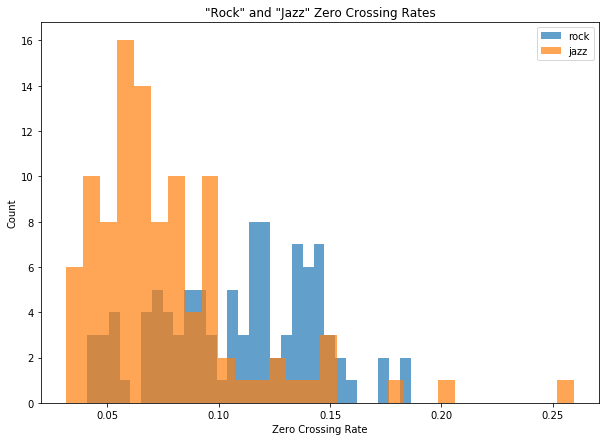

In [22]:
jazz_genre_zcr_means = music_data[music_data.genre=="jazz"].zcr_mean
rock_genre_zcr_means = music_data[music_data.genre=="rock"].zcr_mean


plt.figure(figsize=(10, 7))
plt.hist(rock_genre_zcr_means,bins=30, alpha=0.7, label="rock")
plt.hist(jazz_genre_zcr_means,bins=30, alpha=0.7, label="jazz")

plt.title('"Rock" and "Jazz" Zero Crossing Rates')
plt.xlabel("Zero Crossing Rate")
plt.ylabel("Count")
plt.legend()
plt.show()

In [23]:
sp.stats.ttest_ind(jazz_genre_zcr_means, rock_genre_zcr_means)

Ttest_indResult(statistic=-6.353640063410524, pvalue=1.4150208102321805e-09)

As you can see, the p-value is small so we can say that there's a difference. But we've explored the relationship between "Rock" and "Jazz". Let's explore the other part.

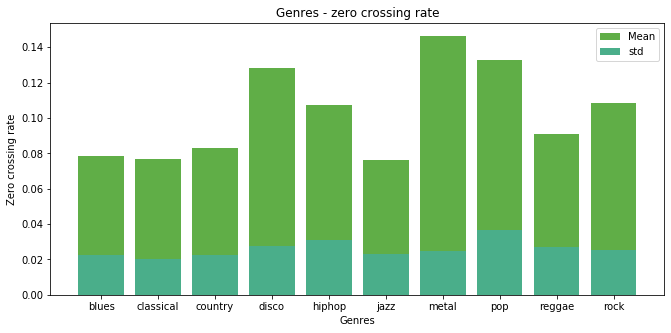

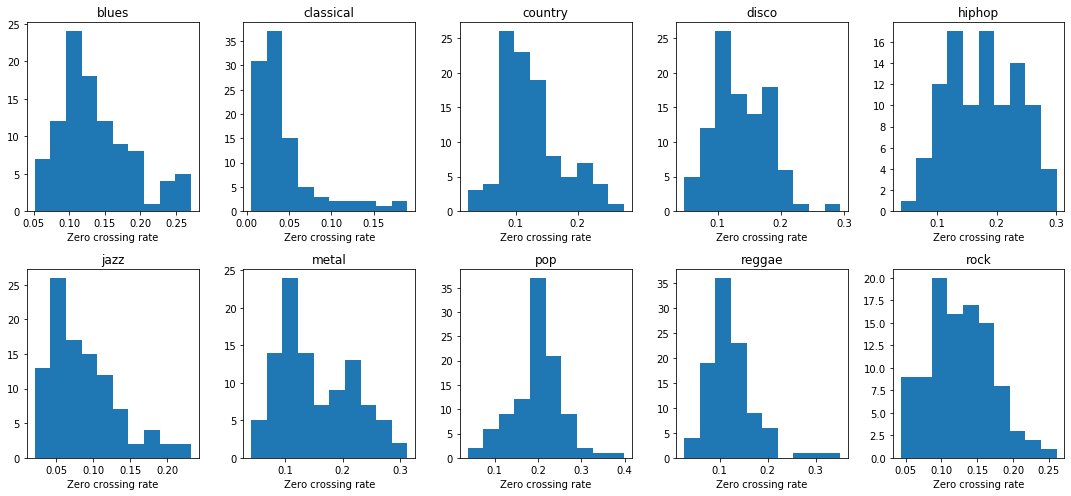

In [24]:
def plot_genres_features_means(feature, title, y_axis = None, plus_std=True):
    genres_feature_means = music_data.groupby(["genre"])[feature+"_mean" if plus_std==True else feature].mean()
    plt.figure(figsize=(11, 5))
    plt.bar(genres_feature_means.index, genres_feature_means.values, label="Mean", color='#60AE47')
    
    if plus_std:
        genres_feature_std_means = music_data.groupby(["genre"])[feature+"_std"].mean()
        plt.bar(genres_feature_std_means.index, genres_feature_std_means.values, label="std", color="#4AAE8A")
        plt.legend()
        
    plt.title(title)
    plt.xlabel("Genres")
    plt.ylabel(y_axis)
    plt.show()
    
    fig = plt.figure(figsize=(15, 7))
    for i, genre_data in enumerate(music_data.groupby("genre")):
        plt.subplot(2, 5, i+1)
        
        plt.hist(genre_data[1].rmse_mean)
        plt.title(genre_data[0])
        plt.xlabel(y_axis)
        
    plt.tight_layout()
    

plot_genres_features_means("zcr", "Genres - zero crossing rate", y_axis="Zero crossing rate")

The biggest zero-crossing rate mean belongs to "Metal", which is the most aggressive genre from all genres in our list.  Let's compare the Metal to the others.

In [25]:
metal_zcr_means = music_data[music_data.genre=="metal"].zcr_mean

In [26]:
metal_zcr_mean = music_data[music_data.genre=="metal"].zcr_mean.mean()
for genre, data in music_data.groupby(["genre"]):
    print(f"Compare metal to {genre}(ZCR)")
    s, p = sp.stats.ttest_ind(data.zcr_mean, metal_zcr_means)
    print(p)
    print(f"Significant difference: {str(p < 0.05).upper()} \n")

Compare metal to blues(ZCR)
3.384368628622954e-31
Significant difference: TRUE 

Compare metal to classical(ZCR)
3.333075788388252e-38
Significant difference: TRUE 

Compare metal to country(ZCR)
1.756089932910182e-31
Significant difference: TRUE 

Compare metal to disco(ZCR)
0.00011211889684886195
Significant difference: TRUE 

Compare metal to hiphop(ZCR)
7.775698137454208e-15
Significant difference: TRUE 

Compare metal to jazz(ZCR)
1.8301648896591578e-31
Significant difference: TRUE 

Compare metal to metal(ZCR)
1.0
Significant difference: FALSE 

Compare metal to pop(ZCR)
0.006386131661196756
Significant difference: TRUE 

Compare metal to reggae(ZCR)
5.411418087408281e-21
Significant difference: TRUE 

Compare metal to rock(ZCR)
3.253842554560238e-13
Significant difference: TRUE 



Ok, we can reject the null hypothesis. But let's make it more general. Let's separate the genres, which have some amount of aggressiveness, from the "chill" genres and then do the same t-test.

In [27]:
not_aggressive_genres_names = ['blues', 'classical', 'country', 'hiphop', 'jazz', 'reggae'] 
not_aggressive_genres = music_data[music_data.genre.isin(not_aggressive_genres_names)]
aggressive_genres = music_data[~music_data.genre.isin(not_aggressive_genres_names)]

sp.stats.ttest_ind(not_aggressive_genres.zcr_mean, aggressive_genres.zcr_mean)

Ttest_indResult(statistic=-18.9095663037455, pvalue=2.125484894950755e-68)

Alright, now we can say that there is really a significant difference. Now let's go to the RMSE.

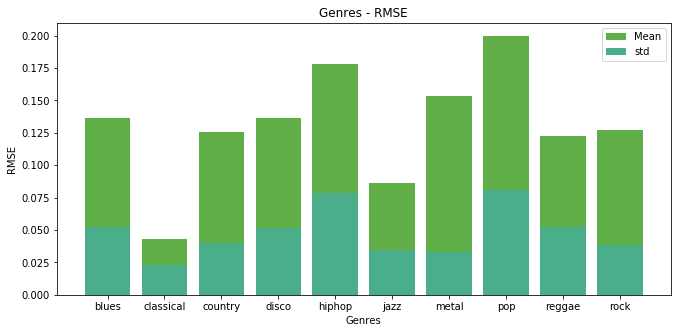

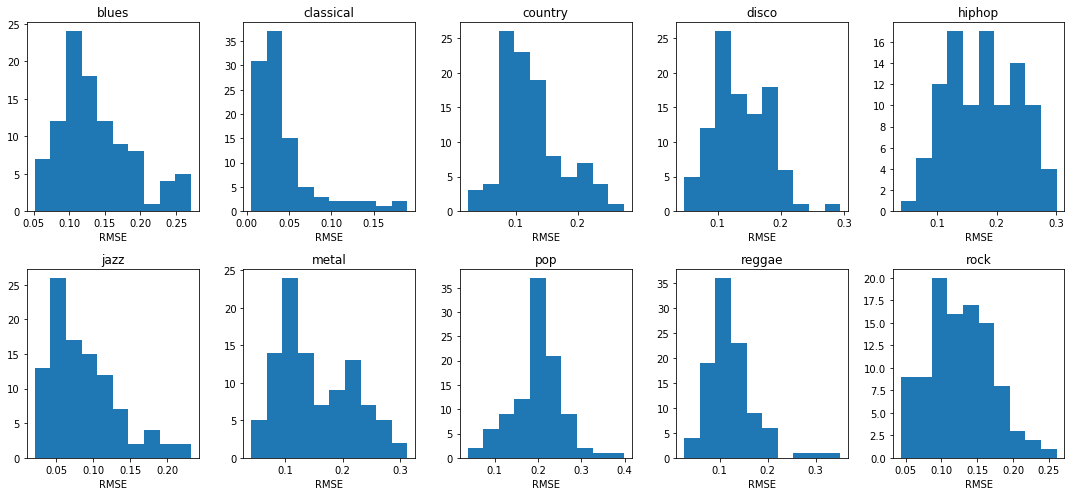

In [28]:
plot_genres_features_means("rmse", "Genres - RMSE", y_axis="RMSE")

We can see that pop, hip-hop, and metal have the biggest amount of energy, but the most consistent is metal. So the metal has the biggest amount of focuses energy. Let's go to the tempo.

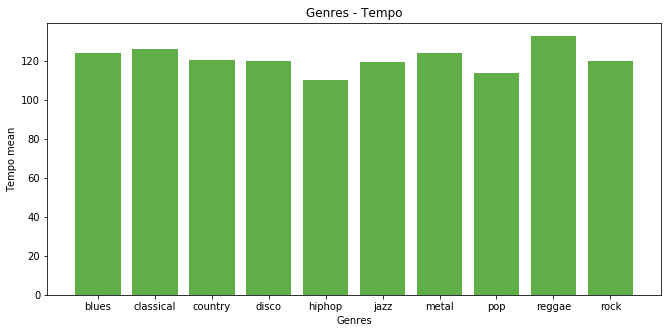

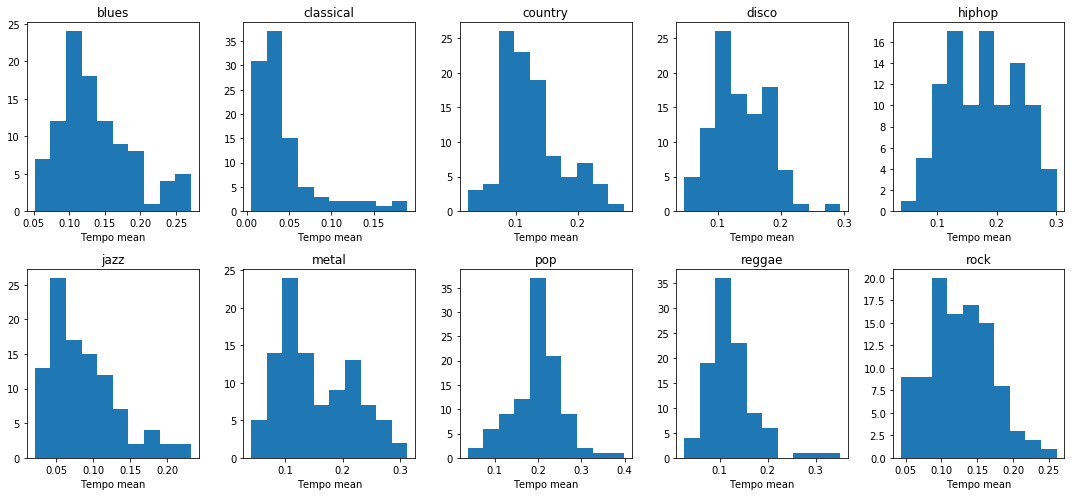

In [29]:
plot_genres_features_means("tempo", "Genres - Tempo", y_axis="Tempo mean", plus_std=False)

In [30]:
music_data.tempo.unique()

array([123, 108, 161, 172, 136, 112,  92,  83, 129, 152,  99, 103,  96,
       144, 117,  89, 185,  86,  76,  70,  81], dtype=int64)

In [31]:
music_data.tempo.unique().shape

(21,)

Let's convert it into a categorical variable. We can do this by simply binning our numerical variable.

In [32]:
music_data.tempo = pd.cut(music_data.tempo.values, 11, labels=False)
music_data.tempo.value_counts()

5     235
4     173
2     154
3     134
7     129
6      68
1      43
8      42
9      16
10      4
0       2
Name: tempo, dtype: int64

We can keep it this way (without "get_dummies", one-hot-encoding) because there is some kind of relation between the categories. For example the second bin mean in bigger than the first etc.

As you can see above, there is was no significant difference where the tempo was a numerical variable. But let's check it now.

In [33]:
tempo_contingency = pd.crosstab(music_data.tempo, music_data.genre)
tempo_contingency

genre,blues,classical,country,disco,hiphop,jazz,metal,pop,reggae,rock
tempo,,,,,,,,,,
0,0,0,2,0,0,0,0,0,0,0
1,5,0,13,2,3,1,3,5,7,4
2,15,9,9,4,44,15,11,22,13,12
3,13,11,7,16,18,21,11,22,3,12
4,10,19,20,20,16,17,22,21,5,23
5,24,30,17,48,4,24,22,17,20,29
6,7,9,8,8,5,9,9,3,4,6
7,14,17,17,0,5,8,17,7,33,11
8,9,4,6,2,1,4,4,2,8,2


In [34]:
_, p, _, _ = sp.stats.chi2_contingency(tempo_contingency)
print(f"p-value: {p}")

p-value: 4.515424860463946e-27


The results from the chi-square test tell us that there is a significant difference(the p-value is < 5%). Now, let's check if there are any correlations between these time-domain features. 

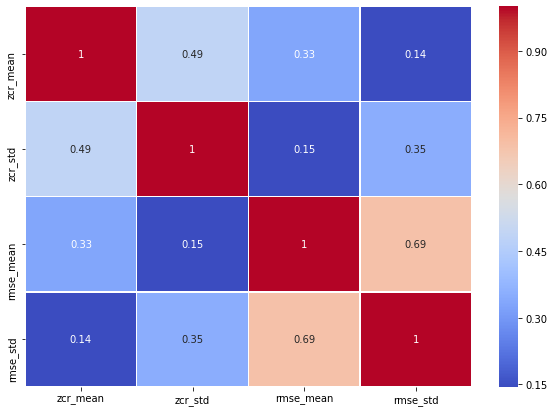

In [35]:
time_domain_corr = music_data[["zcr_mean", "zcr_std", "rmse_mean", "rmse_std"]].corr()
def plot_corr_table(corr_data):
    plt.figure(figsize=(10, 7))
    sns.heatmap(corr_data, linewidths=0.5, annot=True, cmap="coolwarm")
    plt.show()

plot_corr_table(time_domain_corr)

Well, there's nothing intresting at all. Now, let's go tho the features related with the spectrum.

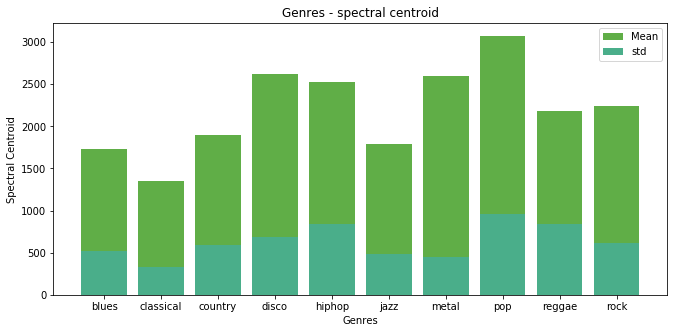

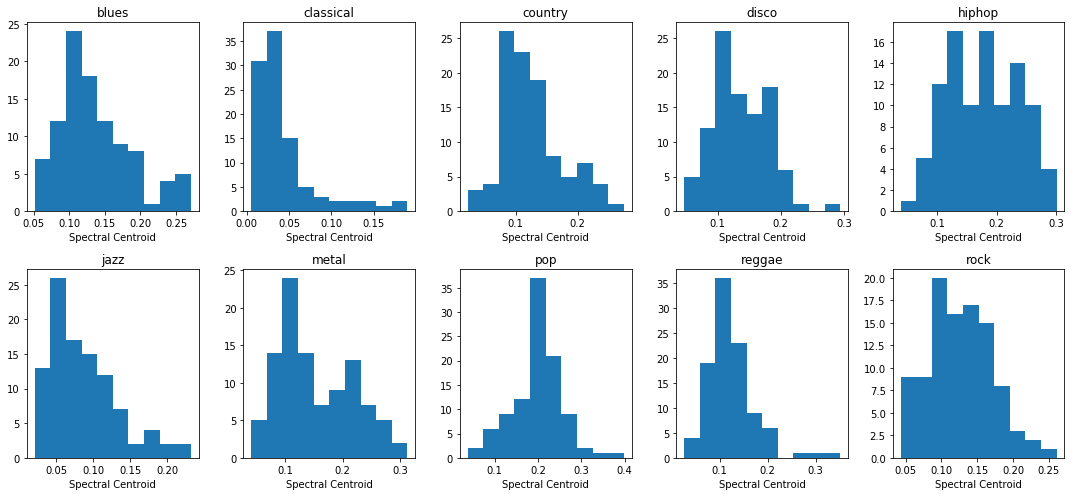

In [36]:
plot_genres_features_means("sp_centroid", "Genres - spectral centroid", y_axis="Spectral Centroid")

Well, we've just seen the means and standard deviations of every genre. But let's get deeper into the standard deviations. The next plot shows us how confident we are when we tell the mean central centroid frequency(how attention we pay to this frequency and around it).

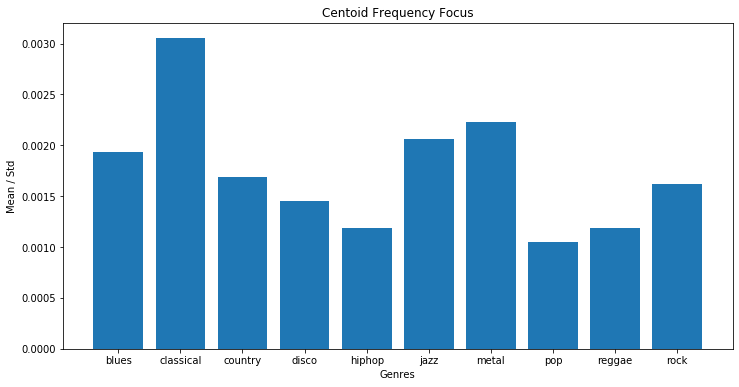

In [37]:
genres_sp_centroid_means = music_data.groupby(["genre"])["sp_centroid_std"].mean() ** -1

plt.figure(figsize=(12, 6))
plt.bar(genres_sp_centroid_means.index, genres_sp_centroid_means.values)

plt.title("Centoid Frequency Focus")
plt.xlabel("Genres")
plt.ylabel("Mean / Std")
plt.show()

The genre with the higher spectral centroid seems to be Pop, but Classical is the most constant(with smaller standard deviation). Metal seems to be the genre with the most focused energy. 

We didn't find any interesting correlations in the time-domain features, but here will be different. Let's see.

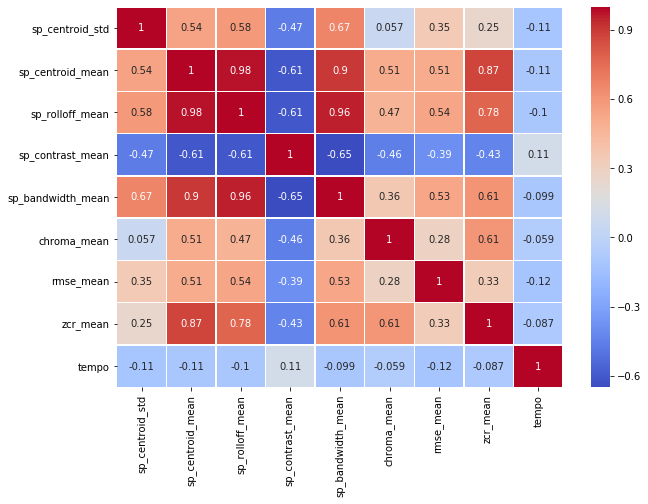

In [38]:
frequency_time_features_corr = music_data[["sp_centroid_std","sp_centroid_mean", "sp_rolloff_mean", "sp_contrast_mean", "sp_bandwidth_mean","chroma_mean", "rmse_mean", "zcr_mean", "tempo"]].corr()
plot_corr_table(frequency_time_features_corr)

There's a strong correlation between the spectral centroid, the spectral roll-off, and the spectral bandwidth. It makes sense because all of them describe one simple thing - the spectral form. If the spectral means increases(the frequency, which separates the spectrum in two equal parts), it naturally increases the frequency, below which lies 85% from the spectrum(the spectral roll-off). The same applies to the spectral bandwidth. The zero-crossing rate is also hardly correlated with the centroid, roll-off, bandwidth, and chroma. A good thing to do here is to remove the unnecessary features because our model will perform better. You can just look at the correlation table above and see that these features have a similar correlation with other features as well. In general, when we have two or more features describing the same thing, it's better to simply remove them. Let's look close to get it.

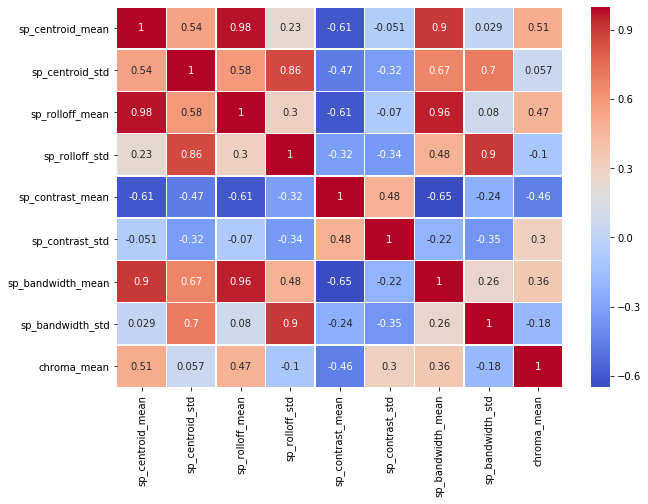

In [39]:
spectral_form_features = music_data[["sp_centroid_mean", "sp_centroid_std", "sp_rolloff_mean", "sp_rolloff_std", "sp_contrast_mean", "sp_contrast_std", "sp_bandwidth_mean", "sp_bandwidth_std", "chroma_mean"]].corr()
plot_corr_table(spectral_form_features)

Ok, now we can see it. We're going to remove the spectral roll-off and use just the spectral centroid. We'll do the same thing for the spectral bandwidth because it shows the width, which is also described in some way by the standard deviation of the spectral centroid.

<small>*This is mainly for algorithms like linear or logistic regression(algorithm which is "linear" at all). Stepped algorithms work in a different way.</small>

In [40]:
music_data.drop(["sp_rolloff_mean", "sp_rolloff_std", "sp_bandwidth_mean", "sp_bandwidth_std"], axis=1, inplace=True)

Now let's plot the information about MFCCs.

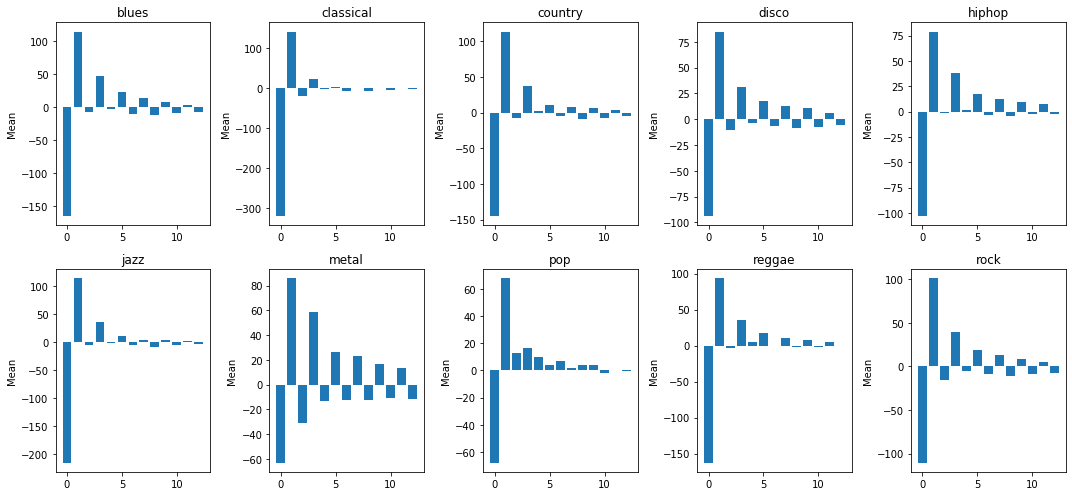

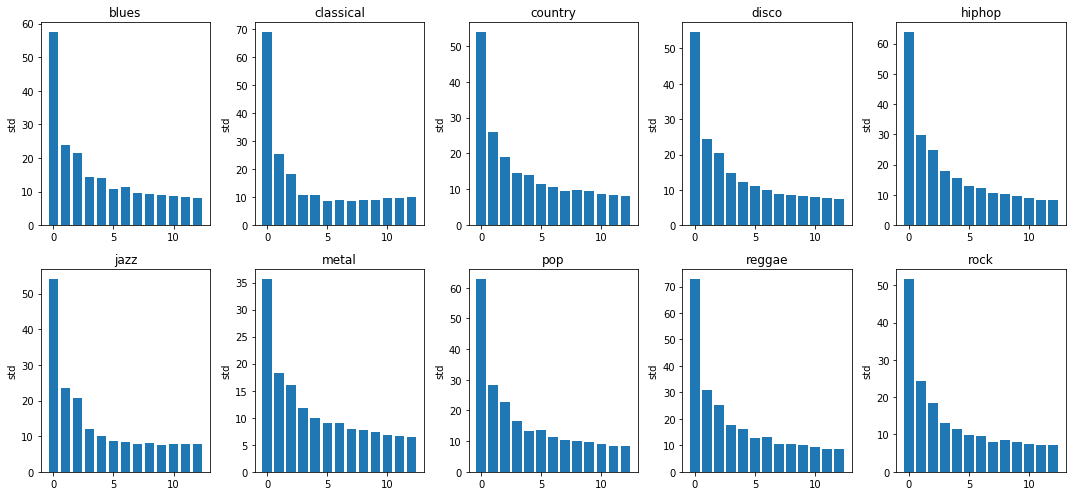

In [41]:
mfccs_mean_columns = music_data.columns[-3:10:-2]
mfccs_std_columns = music_data.columns[-2:10:-2]

def plot_mfcc_per_genre(mfccs_columns, y_axis = "Mean"):
    fig = plt.figure(figsize=(15, 7))
    for i, genre_data in enumerate(music_data.groupby("genre")):
        mfccs = genre_data[1][mfccs_columns[::-1]].mean()
        plt.subplot(2, 5, i+1)
        plt.bar(range(13),mfccs)
        
        plt.title(genre_data[0])
        plt.ylabel(y_axis)
        
    plt.tight_layout()
    plt.show()
    
plot_mfcc_per_genre(mfccs_mean_columns)
plot_mfcc_per_genre(mfccs_std_columns, y_axis="std")

We can see that the bigger part of the variance is in the first 3-4 MFCCs. Now let's visualize the Chroma CENS.

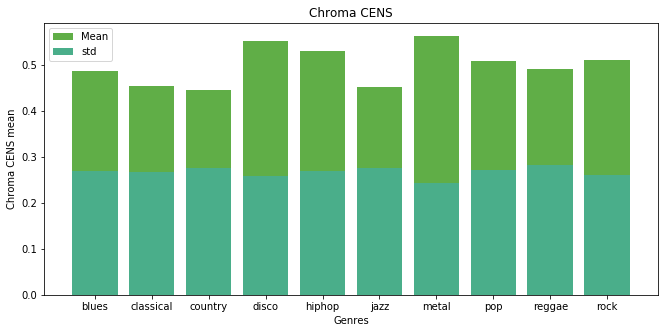

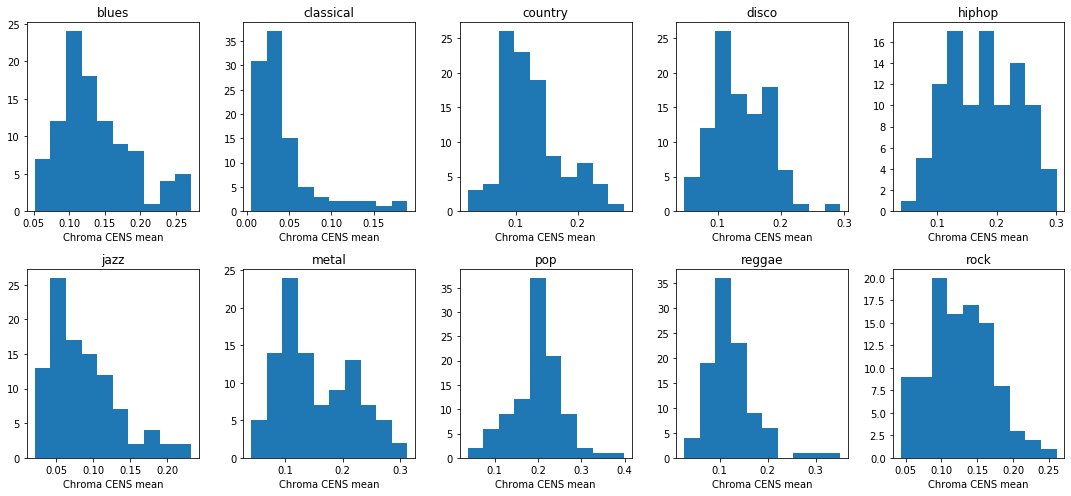

In [42]:
plot_genres_features_means("chroma", "Chroma CENS", y_axis="Chroma CENS mean")

Alright, we've plotted some graphs, we feel comfortable with the data now.

# Data Modelling
## Data Preprocessing And Model Selection

Everything starts with separating the data into two main parts - testing and training data. In practice, 80%(in our case - 800) for training and 20%(200) for testing are preferred. Generally, more data for training is better. Here, we separate the data this way because we have a relatively small dataset. But if you have somehow a very big dataset, you can even leave a 1-2% for testing and 98-99% for training. Another very useful thing is to scale our data. That will make our models work faster and our data will be normalized.

In [43]:
genre_features = music_data.drop(["genre"], axis=1)
genre_labels = music_data.genre

genre_features_train, genre_features_test, genre_labels_train, genre_labels_test = train_test_split(genre_features, genre_labels, train_size=0.80,stratify = genre_labels, random_state = 42)

In [44]:
scaler = StandardScaler()
genre_features_train = scaler.fit_transform(genre_features_train)
genre_features_test = scaler.transform(genre_features_test)

Let's try PCA.

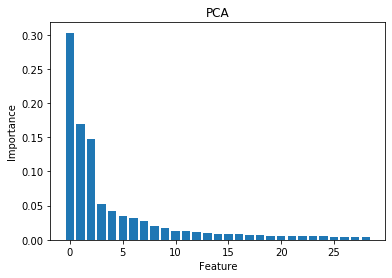

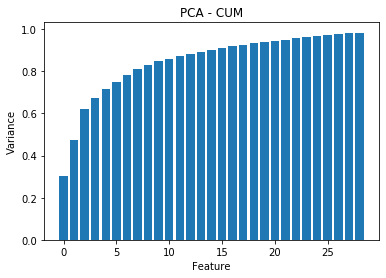

Total number of features: 29


In [45]:
pca = PCA(0.98)
pca.fit(genre_features_train)

plt.bar(range(pca.explained_variance_ratio_.shape[0]), pca.explained_variance_ratio_)

plt.title("PCA")
plt.xlabel("Feature")
plt.ylabel("Importance")
plt.show()

plt.bar(range(pca.explained_variance_ratio_.shape[0]), pca.explained_variance_ratio_.cumsum())
plt.title("PCA - CUM")
plt.xlabel("Feature")
plt.ylabel("Variance")
plt.show()

print(f"Total number of features: {pca.explained_variance_ratio_.shape[0]}")

So we end up with 29 features and 98% from the data. One big misconception is that PCA should be performed on every machine learning algorithm. The only problem here is that this is 100% FALSE. PCA is just a different point of view. But keep in mind - every time you delete some parts of your data, you lose information. So PCA is good when we have too much data, so we can't handle it, because of computational limits. For example, if you have a dataset with 500 000 observations and 2000 features and the PCA says that you can get 98% of your data by using 300-400 features, PCA is a very good option. But in our case, we can't decrease the number of features drastically(for example from 2000 to 200 or 300) so we'll not perform dimensionality reduction. In general, if you don't have computational limits (because you don't have too much data) it's fine to do everything without PCA. But there are different techniques for feature selection. You can try RFE(Recursive Feature Elimination), which is my favorite because you can see the effect on the models directly. Probably we'll do it later.

<small> Just to mention here that there is another misconception about PCA - "PCA reduces overfitting". This is wrong but it's a theme for a different topic. Feature Selection can reduce in some way overfitting.</small>

Now we've already prepared our data it's time to choose our first model. Whenever we have to choose a model we follow these steps:
1) Define the problem(Classification, Regression or another type) 
2) Supervised vs Unsupervised

We also have different models, from which we can choose as we sort them by their difficulty(from linear models, trees, SVMs to ensembles, etc.). Probably the simplest model that comes to my mind is the logistic regression. We'll perform a grid search just to see how the best model fits the data to get a reference about what the best accuracy score is. Let's try it and then see what the algorithm thinks about our decision :D.

In [3]:
## Just some helper functions to backup our models with pickle
def pickle_backup(obj, path):  
    pickle_out = open(path, "wb")
    pickle.dump(obj, pickle_out)
    pickle_out.close()
    
def pickle_load(path):
    pickle_out = open(path, "rb")
    obj = pickle.load(pickle_out)
    pickle_out.close()
    return obj

def get_grid_scores(grid_obj):
    cv_std= grid_obj.cv_results_['std_test_score'][grid_obj.best_index_]
    cv_mean = grid_obj.best_score_
    
    return (cv_mean, cv_std)

log_reg_params = {
    "C" : [1e-1, 1, 10, 1e2, 1e3, 1e4],
    "max_iter":[50, 100, 200, 300],
    "fit_intercept" : [True, False],
    "penalty": ["l2", "l1"],
    "n_jobs": [-1]
}

if os.path.exists("Data/models/grid_log_reg.pickle") == False:
    grid_log_reg = GridSearchCV(LogisticRegression(), log_reg_params, scoring="accuracy", cv=5, n_jobs=-1)
    grid_log_reg.fit(genre_features_train, genre_labels_train)
    pickle_backup(grid_log_reg, "Data/models/grid_log_reg.pickle")
else:
    grid_log_reg = pickle_load("Data/models/grid_log_reg.pickle")
    
log_reg = grid_log_reg.best_estimator_
log_reg

LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=50,
                   multi_class='warn', n_jobs=-1, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

Another thing to mention here. The matric an important part of finding the best model. But it's not a big problem for us, because our data is well balanced so we can use the default accuracy matric. Let's see the report.

Logistic Regression Reports: 

Classification Report Based on CV with 5 folds
╒═══════════╤═══════════════╤═══════════════╤═══════════════╕
│ genre     │ precision     │ recall        │ f1            │
╞═══════════╪═══════════════╪═══════════════╪═══════════════╡
│ blues     │ 0.67(+/-0.12) │ 0.71(+/-0.09) │ 0.69(+/-0.08) │
├───────────┼───────────────┼───────────────┼───────────────┤
│ classical │ 0.89(+/-0.07) │ 0.92(+/-0.05) │ 0.9(+/-0.03)  │
├───────────┼───────────────┼───────────────┼───────────────┤
│ country   │ 0.64(+/-0.05) │ 0.69(+/-0.1)  │ 0.66(+/-0.06) │
├───────────┼───────────────┼───────────────┼───────────────┤
│ disco     │ 0.67(+/-0.09) │ 0.57(+/-0.02) │ 0.62(+/-0.04) │
├───────────┼───────────────┼───────────────┼───────────────┤
│ hiphop    │ 0.73(+/-0.09) │ 0.64(+/-0.08) │ 0.68(+/-0.07) │
├───────────┼───────────────┼───────────────┼───────────────┤
│ jazz      │ 0.72(+/-0.11) │ 0.68(+/-0.06) │ 0.69(+/-0.06) │
├───────────┼───────────────┼───────────────┼─────────

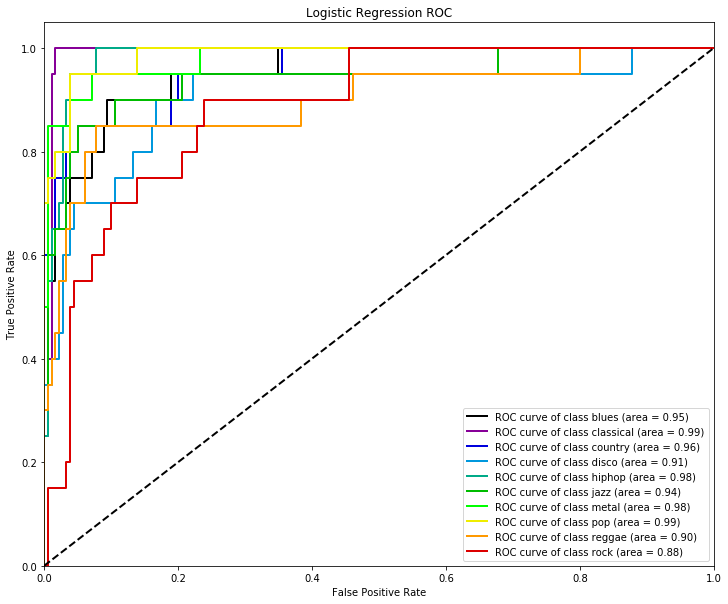

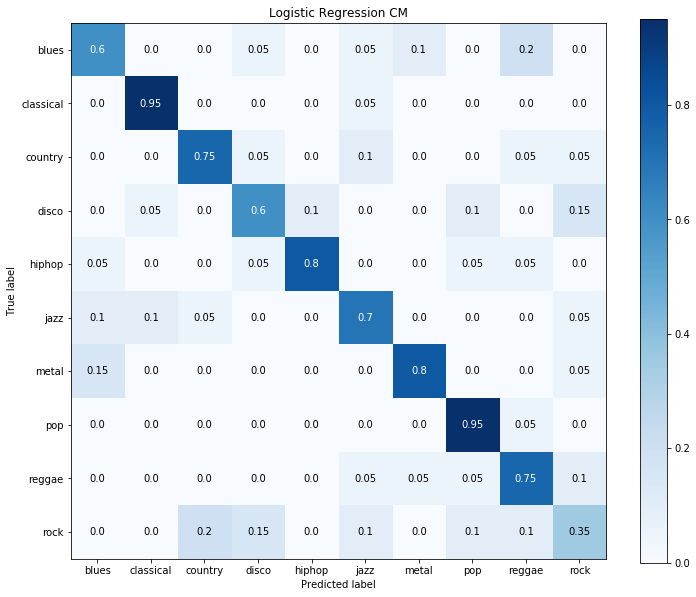

In [47]:
warnings.simplefilter("ignore")

def print_cv_report(x, y, estimator, cv = 5):
    '''Prints the classification report with cross-validation'''

    
    global score_vals
    score_vals = np.array([])
    
    def classification_report_with_accuracy_score(y_true, y_pred):
        global score_vals
        report = classification_report(y_true, y_pred, output_dict=True)
        report_genres = list(itertools.islice(report.items(), 10))
        report_accuracy = list(itertools.islice(report.items(), 10, 11))[0][1]
        for key, value in report_genres:
            genre_precision = value["precision"]
            genre_recall = value["recall"]
            genre_f1 = value["f1-score"]
            score_vals = np.append(score_vals, [genre_precision, genre_recall, genre_f1])
        return report_accuracy
    
    cv_score = cross_val_score(estimator, X=x, y=y, cv=cv,
                   scoring=make_scorer(classification_report_with_accuracy_score))
    
    score_vals = score_vals.reshape((cv, 10, 3))
    
    genre_names = ['blues', 'classical', 'country', 'disco', 'hiphop', 'jazz',
       'metal', 'pop', 'reggae', 'rock']
    genre_precision_mean, genre_precision_std = score_vals[:, :, 0].mean(axis=0), score_vals[:, :, 0].std(axis=0)
    genre_recall_mean, genre_recall_std = score_vals[:, :, 1].mean(axis=0), score_vals[:, :, 1].std(axis=0)
    genre_f1_mean, genre_f1_std = score_vals[:, :, 2].mean(axis=0), score_vals[:, :, 2].std(axis=0)
    accuracy_mean, accuracy_std  = cv_score.mean(),cv_score.std()
    
    
    table_data = np.array([])
    for genre, precision_mean, precision_std, recall_mean, recall_std , f1_mean, f1_std in zip(genre_names, genre_precision_mean, genre_precision_std,
                                                                                       genre_recall_mean, genre_recall_std,
                                                                                        genre_f1_mean, genre_f1_std):
        table_data = np.append(table_data, [genre, f"{str(round(precision_mean, 2))}(+/-{str(round(precision_std, 2))})",
                                      f"{str(round(recall_mean, 2))}(+/-{str(round(recall_std, 2))})",
                                      f"{str(round(f1_mean, 2))}(+/-{str(round(f1_std, 2))})"])
    table_data = table_data.reshape(10, 4)
    general_info = [
        ["Accuracy", round(cv_score.mean(), 2), round(cv_score.std(), 2)],
        ["Precision", round(genre_precision_mean.mean(), 2), round(genre_precision_mean.std(), 2)],
        ["Recall", round(genre_recall_mean.mean(), 2), round(genre_recall_mean.std(), 2)],        
        ["F1-score", round(genre_f1_mean.mean(), 2), round(genre_f1_mean.std(), 2)]
    ]
    print(f"Classification Report Based on CV with {cv} folds")
    print(tabulate(table_data, headers=["genre", "precision","recall", "f1"], tablefmt='fancy_grid'))
    print(70 * "-")
    print(f"Metrics mean based on CV with {cv} folds")
    print(tabulate(general_info, headers=["metric", "mean", "std"], tablefmt="fancy_grid"))
    print(70 * "-")

    del score_vals


def plot_roc_curve(estimator, x_test, y_true, curve=("each_class"), title="Roc Curves"):
    '''Prints roc curve'''
    y_proba = estimator.predict_proba(x_test)
    skplt.metrics.plot_roc_curve(y_true, y_proba,title, curves = curve, figsize=(12, 10))
    
def plot_confusion_matrix(y_pred, y_true, title="Normalized Confusion Matrix"):
    '''Prints confusion matrix'''
    skplt.metrics.plot_confusion_matrix(y_true, y_pred, title=title,normalize=True, figsize=(12, 10))
    plt.show()
    
def print_report(x, y_true, model, title="Classification Report on Testing Set", model_name=None):
    '''Prints the classification report as well as the roc curve and the confusion matrix'''
    y_predict = model.predict(x)
    print(title)
    print(classification_report(y_true, y_predict, digits=2))
    plot_roc_curve(model, x, y_true, title= model_name+" ROC" if model_name != None else "Roc Curves")
    plot_confusion_matrix(y_predict, y_true, title= model_name+" CM" if model_name != None else "Normalized Confusion Matrix")
    
print("Logistic Regression Reports: \n")
print_cv_report(genre_features_train, genre_labels_train, log_reg, cv=5)
print_report(genre_features_test, genre_labels_test, log_reg,
             "Test set", "Logistic Regression")

The good news - the model doesn't overfit the data. The bad news - there are some problematical genres. All of the plots show us that the biggest problem comes when it should recognize a rock song. This problem can be due to the data (we need to extend the dataset) or to the model. Let's see the RFE curve because the logistic regression is very good at showing which features are meaningless.

In [48]:
def select_features(estimator, x, y):
    rfecv = RFECV(estimator, cv=5)
    rfecv.fit(x, y)
    plt.figure(figsize=(16, 6))
    plt.title('Recursive Feature Elimination with Cross-Validation', fontsize=18, fontweight='bold', pad=20)
    plt.xlabel('Number of features selected', fontsize=14, labelpad=20)
    plt.ylabel('% Correct Classification', fontsize=14, labelpad=20)
    plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_, color='#303F9F', linewidth=3)
    plt.show()
    return rfecv

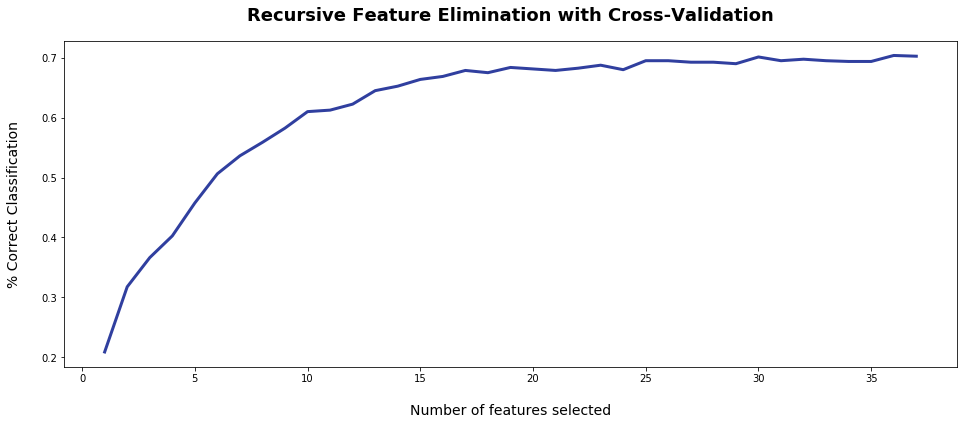

In [49]:
log_selector = select_features(log_reg, genre_features_train, genre_labels_train)

Alright, there are no reasons to remove features because we don't have a nice cut-off. Now let's try something more powerful - SVM. We're going to try a linear SVM firstly and then something more interesting. Just look at the code below.

In [50]:
svc_params = [{
    'C': [1e-1, 1, 1e1, 1e2, 1e3, 1e4],
    'gamma': [7e-4, 1e-3, 7e-3, 2e-2, 1e-1, 1],
    'kernel': ['rbf'],
    'probability': [True]
}, {
    'C': [1e-1, 1, 1e1, 1e2, 1e3, 1e4],
    'kernel':['linear'],
    'probability': [True]
}]
if os.path.exists("Data/models/grid_svc.pickle") == False:
    grid_svc = GridSearchCV(SVC(), svc_params, scoring="accuracy", cv=5, n_jobs=-1)
    grid_svc.fit(genre_features_train, genre_labels_train)
    pickle_backup(grid_svc, "Data/models/grid_svc.pickle")
else:
    grid_svc = pickle_load("Data/models/grid_svc.pickle")
svm = grid_svc.best_estimator_
svm

SVC(C=10.0, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=0.02, kernel='rbf',
    max_iter=-1, probability=True, random_state=None, shrinking=True, tol=0.001,
    verbose=False)

Classification Report Based on CV with 10 folds
╒═══════════╤═══════════════╤═══════════════╤═══════════════╕
│ genre     │ precision     │ recall        │ f1            │
╞═══════════╪═══════════════╪═══════════════╪═══════════════╡
│ blues     │ 0.79(+/-0.13) │ 0.84(+/-0.13) │ 0.81(+/-0.1)  │
├───────────┼───────────────┼───────────────┼───────────────┤
│ classical │ 0.91(+/-0.1)  │ 0.9(+/-0.08)  │ 0.9(+/-0.05)  │
├───────────┼───────────────┼───────────────┼───────────────┤
│ country   │ 0.67(+/-0.17) │ 0.72(+/-0.22) │ 0.69(+/-0.19) │
├───────────┼───────────────┼───────────────┼───────────────┤
│ disco     │ 0.68(+/-0.11) │ 0.72(+/-0.13) │ 0.69(+/-0.07) │
├───────────┼───────────────┼───────────────┼───────────────┤
│ hiphop    │ 0.74(+/-0.13) │ 0.7(+/-0.14)  │ 0.71(+/-0.09) │
├───────────┼───────────────┼───────────────┼───────────────┤
│ jazz      │ 0.77(+/-0.1)  │ 0.78(+/-0.16) │ 0.77(+/-0.11) │
├───────────┼───────────────┼───────────────┼───────────────┤
│ metal     │ 0.88(+/-

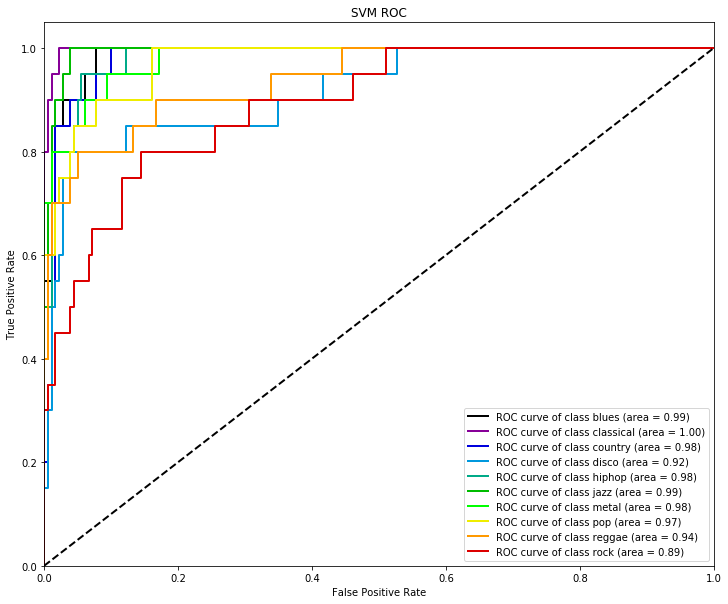

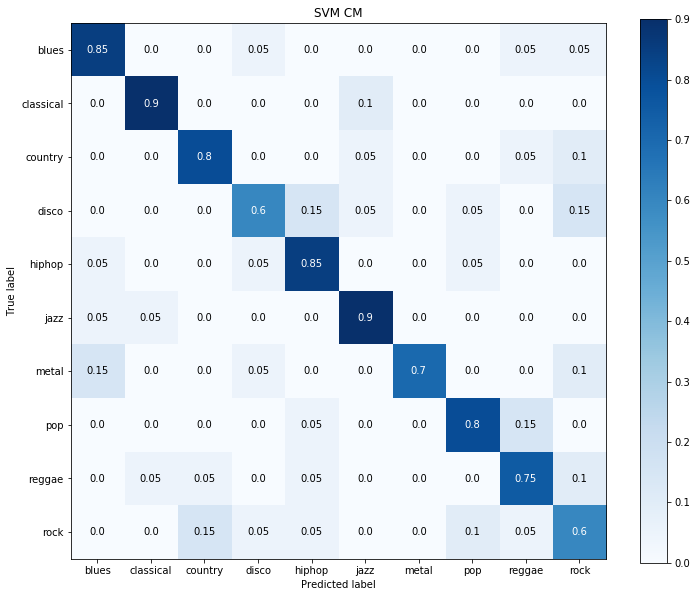

In [51]:
print_cv_report(genre_features_train, genre_labels_train, svm, cv=10)
print_report(genre_features_test, genre_labels_test, svm, model_name="SVM")

Alright, it looks nice. The SVMs are very good when the dataset is small. We decrease the problem with the "Rock" genre. And this model is better than the logistic regression because it decreases the variance in precision, recall, and f1-score. We didn't overfit the data:D. But how deep can we get? Let's try something brutal, let's be aggressive.

Yeah - It's time for Random Forest :D

In [4]:
param_grid = { 
    "criterion" : ["gini", "entropy"],
    'max_depth': [10, 20, 30, 40, 50],
    "min_samples_leaf" : [1, 5, 10], 
    "min_samples_split" : [2, 4, 10, 12, 16], 
    "n_estimators": [100, 400, 700, 1000, 1200],
    'bootstrap': [True],
}

if os.path.exists("Data/models/grid_rf.pickle") == False:
    grid_rf = GridSearchCV(RandomForestClassifier(max_features='auto', oob_score=True, random_state=1, n_jobs=-1), param_grid=param_grid, scoring='accuracy', cv=3, n_jobs=-1)
    grid_rf.fit(genre_features_train, genre_labels_train)
    grid_rf.fit(genre_features_train, genre_labels_train)
    pickle_backup(grid_rf, "Data/models/grid_rf.pickle")
else:
    grid_rf = pickle_load("Data/models/grid_rf.pickle")
rf = grid_rf.best_estimator_
rf

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=20, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=1000,
                       n_jobs=-1, oob_score=True, random_state=1, verbose=0,
                       warm_start=False)

Classification Report Based on CV with 5 folds
╒═══════════╤═══════════════╤═══════════════╤═══════════════╕
│ genre     │ precision     │ recall        │ f1            │
╞═══════════╪═══════════════╪═══════════════╪═══════════════╡
│ blues     │ 0.76(+/-0.08) │ 0.72(+/-0.08) │ 0.74(+/-0.07) │
├───────────┼───────────────┼───────────────┼───────────────┤
│ classical │ 0.92(+/-0.06) │ 0.91(+/-0.06) │ 0.91(+/-0.03) │
├───────────┼───────────────┼───────────────┼───────────────┤
│ country   │ 0.63(+/-0.1)  │ 0.6(+/-0.19)  │ 0.6(+/-0.14)  │
├───────────┼───────────────┼───────────────┼───────────────┤
│ disco     │ 0.58(+/-0.09) │ 0.64(+/-0.08) │ 0.6(+/-0.08)  │
├───────────┼───────────────┼───────────────┼───────────────┤
│ hiphop    │ 0.69(+/-0.09) │ 0.56(+/-0.14) │ 0.6(+/-0.08)  │
├───────────┼───────────────┼───────────────┼───────────────┤
│ jazz      │ 0.72(+/-0.12) │ 0.79(+/-0.03) │ 0.75(+/-0.07) │
├───────────┼───────────────┼───────────────┼───────────────┤
│ metal     │ 0.78(+/-0

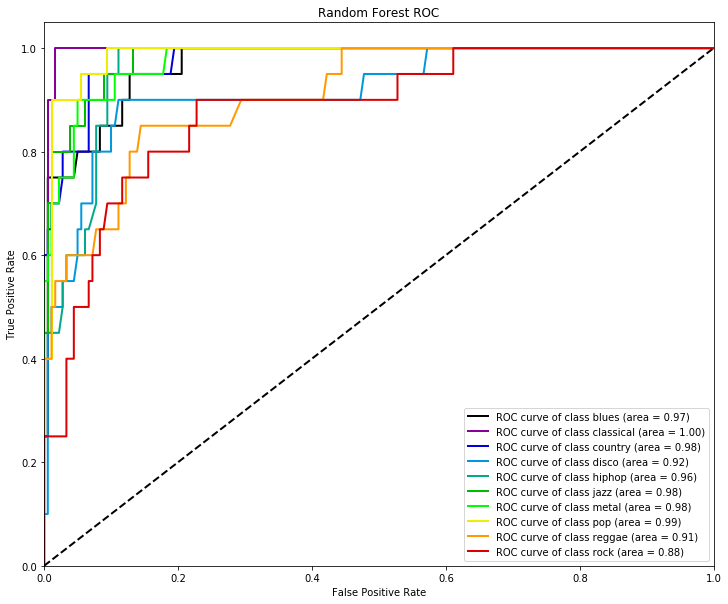

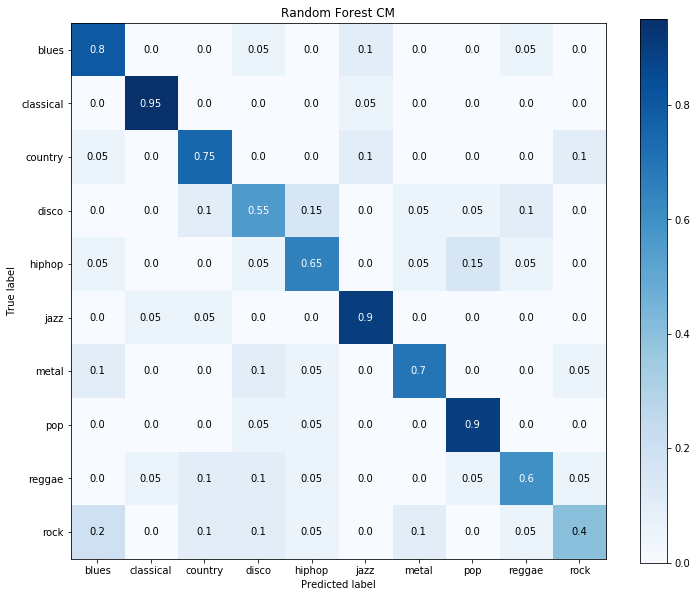

In [53]:
print_cv_report(genre_features_train, genre_labels_train, rf)
print_report(genre_features_test, genre_labels_test, rf, model_name="Random Forest")

Cool thing about RF is that we can see the features importances. They seem to be approximately equal.

In [6]:
np.round(rf.feature_importances_, 2)

array([0.03, 0.01, 0.01, 0.05, 0.05, 0.04, 0.04, 0.04, 0.04, 0.03, 0.02,
       0.05, 0.03, 0.03, 0.02, 0.02, 0.02, 0.05, 0.03, 0.02, 0.04, 0.03,
       0.02, 0.02, 0.03, 0.02, 0.02, 0.03, 0.02, 0.02, 0.02, 0.02, 0.02,
       0.03, 0.02, 0.02, 0.02])

Well, the SVM seems to be better than the random forest. Let's compare the models and choose the best one.

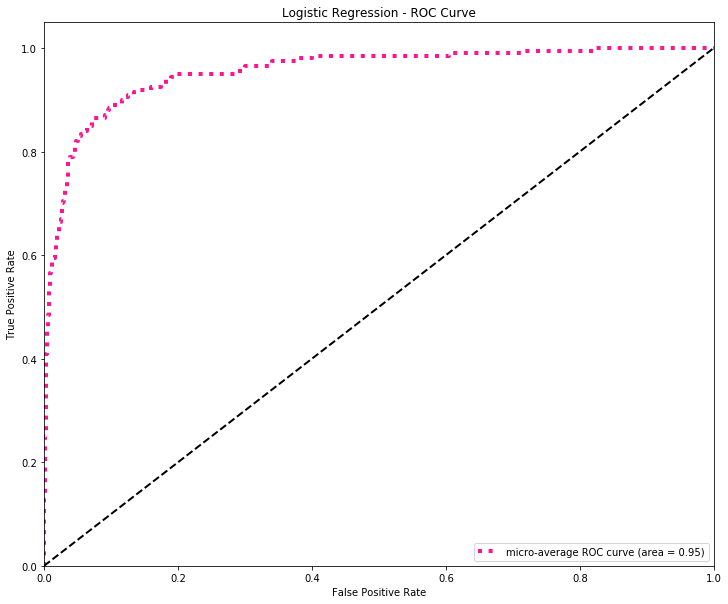

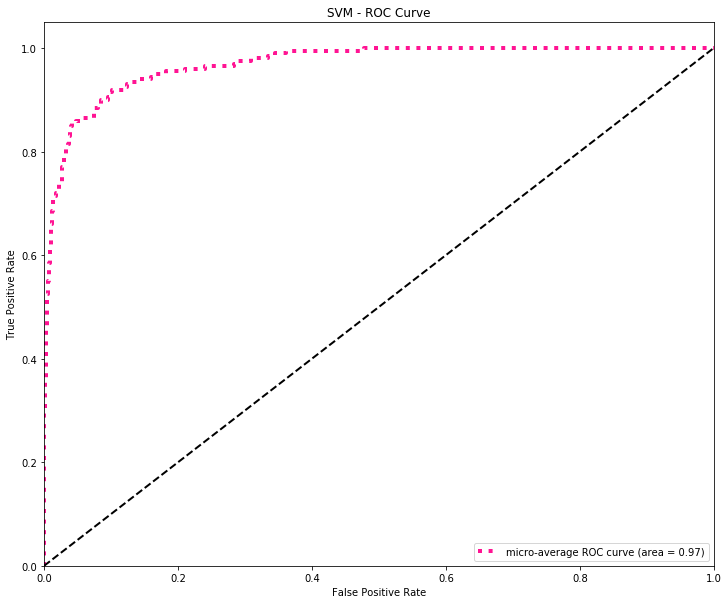

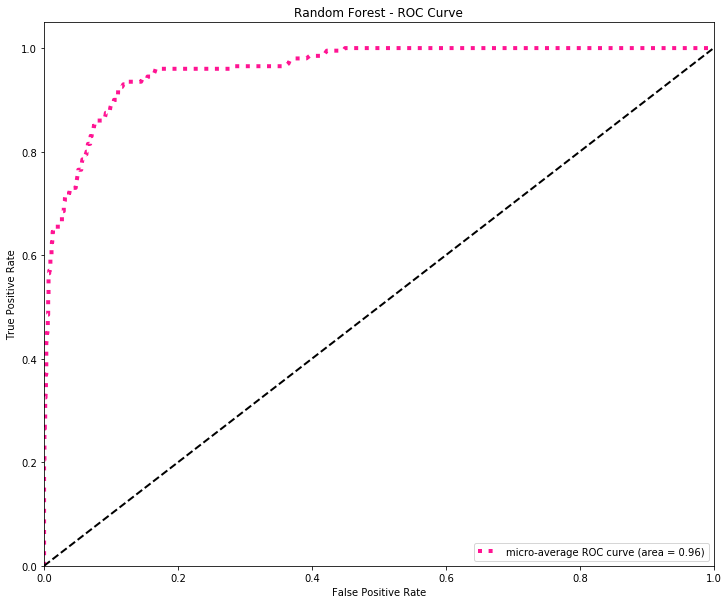

In [54]:
plot_roc_curve(log_reg, genre_features_test, genre_labels_test, curve=("micro"), title="Logistic Regression - ROC Curve")
plot_roc_curve(svm, genre_features_test, genre_labels_test, curve=("micro"), title="SVM - ROC Curve")
plot_roc_curve(rf, genre_features_test, genre_labels_test, curve=("micro"), title="Random Forest - ROC Curve")

All things which we've already seen above this section show us that if we should summarise the results they will be:
<ol>
    <li>SVM - AUC=0.97, CV score=0.74(+/-0.04), Test score = 0.78</li>
    <li>Logistic Regression - AUC=0.95, CV score=0.70(+/-0.03), Test score = 0.73</li>
    <li>Random Forest - AUC=0.96, CV score=0.69(+/-0.05), Test score = 0.72</li>
</ol>

Our winner is SVM.

# Conclusion
Although we achieve only 78% accuracy, the main idea of this paper isn't to just show some results, but to think. Sometimes a human can also mistake the genre of a song. There isn't a human with a 100% accuracy so... 

In the end, I can say that maybe if someone wants to extend this research, the next step is some kind of neural network. In my next project, I will train a CNN network to classify genres by their spectrogram image using much bigger dataset called <a href="https://github.com/mdeff/fma">FMA</a>. But on the internet now, the results from ML models(music classification) are close to the ones in this notebook. The notebook introduces the problem and explores how popular machine learning algorithms handle it. But the best is yet to come.

### References
<small>Some references, which I found during the research</small>
<ul>
<li><a href="https://medium.com/data-design/how-to-not-be-dumb-at-applying-principal-component-analysis-pca-6c14de5b3c9d">How to not be dumb at applying Principal Component Analysis (PCA)?</a></li>
    
<li><a href="https://medium.com/@sadatnazrul/the-dos-and-donts-of-principal-component-analysis-7c2e9dc8cc48">The DOs and DON’Ts of Principal Component Analysis</a></li>
    
<li><a href="https://musicinformationretrieval.com/index.html">Librosa notebooks</a></li>

<li><a href="https://librosa.github.io/librosa/">Librosa Docs</a>

<li><a href="http://conference.scipy.org/proceedings/scipy2015/pdfs/brian_mcfee.pdf">Audio and Music Signal Analysis in Python</a></li>

<li><a href="./MathAndMusicPaper/MathAndMusic.ipynb">Math in Music paper</a></li>

</ul>
